# Note
* **Objective**: predict the covid test results
* The major aim is to optimize the **recall** (few false negative, FN: positive (covid-infected) cases wrongly predicted as negative)
* Only 100,000 rows of data is loaded for the sake of modeling speed
* Many lines of script in this notebook are taken from [Metis bootcamp](https://www.thisismetis.com/) teaching materials

# - - - Part 1: Prepare data - - -

# Load packages

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import itertools
import warnings
warnings.filterwarnings("ignore")

# for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
pd.options.display.max_rows = 500 # display max rows
# pd.options.display.float_format = '{:.2f}'.format #supress scientific notation

# display full output in Jupyter, not only last result.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# sklearn - data preparation
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# sklearn - classification models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier

from mlxtend.classifier import StackingClassifier

# evaluation metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import learning_curve, GridSearchCV

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# from plot import *

# plt.figure(figsize=(12,12), dpi=200)

In [2]:
import sklearn
import sys
import matplotlib

libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd), ('Sklearn', sklearn))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.7.1 (default, Oct 28 2018, 08:39:03) [MSC v.1912 64 bit (AMD64)] 

Matplotlib Version: 3.1.3
Numpy Version: 1.20.1
Pandas Version: 1.2.4
Sklearn Version: 0.24.1


# Data preparation
Here are some variables and data that will be used throughout this script
* `df_model`, `X`, `y`: cleaned dataframe
* `X_train`, `T_test`, `y_train`, `y_test`: split and scaled dataset for modeling
* `df_train`=`X_train`+`y_train`,  `df_test`=`X_test`+`y_test`
* `col_X`, `col_y`: columns for features and target

## df_model
* load the cleaned dataset and save as `df_model` for future use
* requirement: first N-1 columns as features, the last Nth column as the target

In [3]:
## - - - Covid dataset - - -
df = pd.read_pickle('data/' + 'df_covid_100000rows.pkl')
df = df.sample(10000) # use this for time saving

print(df.shape)

df = df.reset_index(drop = True)

df_model = df

df.head()

(10000, 10)


,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,contact_with_confirmed,abroad,corona_result
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0


In [4]:
df = df_model

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   cough                   10000 non-null  int32
 1   fever                   10000 non-null  int32
 2   sore_throat             10000 non-null  int32
 3   shortness_of_breath     10000 non-null  int32
 4   head_ache               10000 non-null  int32
 5   age_60_and_above        10000 non-null  int64
 6   gender                  10000 non-null  int64
 7   contact_with_confirmed  10000 non-null  int64
 8   abroad                  10000 non-null  int64
 9   corona_result           10000 non-null  int64
dtypes: int32(5), int64(5)
memory usage: 586.1 KB


In [5]:
# value_counts for all columns, only works for pandas > 1.1.0

df = df_model

cat_cols = df.columns.tolist()
(pd.DataFrame(
    df[cat_cols]
    .melt(var_name='column', value_name='value')
    .value_counts())
.rename(columns={0: 'counts'})
.sort_values(by=['column', 'counts']))

counts
column                 value        
abroad                 1         145
                       0        9855
age_60_and_above       1        1301
                       0        8699
contact_with_confirmed 1         666
                       0        9334
corona_result          1         957
                       0        9043
cough                  1         510
                       0        9490
fever                  1         442
                       0        9558
gender                 1        4806
                       0        5194
head_ache              1         260
                       0        9740
shortness_of_breath    1          43
                       0        9957
sore_throat            1         127
                       0        9873

## X/y split, `col_X`, `col_y`
* `col_X` and `col_y` will be used through out this script for the classification training
* specific format for the `df_model`: totally N columns, first N-1 columns for feature and right-most column for target

In [6]:
df = df_model

col_X = list(df.columns)[0:-1]
col_y = list(df.columns)[-1:]

print('features:', col_X)
print('target:', col_y)

X_raw = df[col_X]
y = df[col_y]

feature_names = col_X
target_names = col_y
target_values = list(df[col_y[0]].unique())

# check target values
df[col_y[0]].value_counts(normalize = False)
df[col_y[0]].value_counts(normalize = True)

features: ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'contact_with_confirmed', 'abroad']
target: ['corona_result']


0    9043
1     957
Name: corona_result, dtype: int64

0    0.904
1    0.096
Name: corona_result, dtype: float64

## Train/test split (`X_train`, `y_train`, `df_train`)

In [7]:
# split X and y into training and testing sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

## Scaling (`X`, `X_train`, `X_test`)

In [8]:
# transform as numpy array and transfer back to the datafram
from sklearn import preprocessing

# scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_raw.values)
X_train = pd.DataFrame(X_train_scaled)
X_train.columns = col_X

X_test_scaled = scaler.fit_transform(X_test_raw.values)
X_test = pd.DataFrame(X_test_scaled)
X_test.columns = col_X

X_scaled = scaler.fit_transform(X_raw.values)
X = pd.DataFrame(X_scaled)
X.columns = col_X

# save df_train and df_test for some future tests
df_train = X_train.copy()
df_train[col_y] = y_train.copy()
df_test = X_test.copy()
df_test[col_y] = y_test.copy()

# reset.index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# this are non-modified files, which can be used for additional modeling work
X_copy, y_copy = X, y
X_train_copy, X_test_copy, y_train_copy, y_test_copy = X_train, X_test, y_train, y_test

## quick check

In [9]:
# print the type
type(X)
type(y)

pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

In [10]:
# print the shapes of X and y
print(X.shape, y.shape)

(10000, 9) (10000, 1)


In [11]:
# print the shapes of the new X objects
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 9) (2000, 9) (8000, 1) (2000, 1)


In [12]:
# print the shapes of the data frames
print(df_train.shape, df_test.shape)

(8000, 10) (2000, 10)


In [13]:
X_train.head()
y_train.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,contact_with_confirmed,abroad
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,corona_result
0,1
1,0
2,0
3,0
4,0


In [14]:
X_train.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,contact_with_confirmed,abroad
count,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000
mean,0.051,0.045,0.014,0.004,0.027,0.130,0.487,0.066,0.015
std,0.219,0.206,0.116,0.065,0.162,0.336,0.500,0.248,0.120
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [15]:
y_train[col_y[0]].value_counts()

0    7242
1     758
Name: corona_result, dtype: int64

# - - - Part 2: Modeling - - -

# Dummy model ...

Covid data
* Dummy model gives a good accuracy, due to the class imbalance

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='stratified') #most_frequent
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

confusion_matrix(y_test, y_pred)

print('accuracy:', round(accuracy_score(y_test, y_pred), 3))
print('precision:', round(precision_score(y_test, y_pred), 3))
print('recall:', round(recall_score(y_test, y_pred), 3))
print('f1:', round(f1_score(y_test, y_pred), 3))

DummyClassifier(strategy='stratified')

array([[1632,  169],
       [ 171,   28]], dtype=int64)

accuracy: 0.83
precision: 0.142
recall: 0.141
f1: 0.141


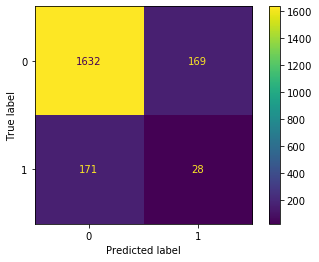

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.grid(False)

# Rapid tests - a few models
* mostly from my previous `NBA script`

## Test models, scores, and plot

For covid data
* just testing common models with default parameters, will tune parameters later
* not surprisingly, due to the class imbalance, the accuracy is > 90% for most models
* the key metric, recall, is generally as low as 0.6 for most models (we will tune this later)

In [18]:
# get the scores from models

df_score = pd.DataFrame()

mydict_models =  {
    'Logistic': LogisticRegression(), 
    'KNN': KNeighborsClassifier(), 
    'GaussianNB': GaussianNB(),
    'SVC': SVC(), 
    'Tree': DecisionTreeClassifier(), 
    'Forest': RandomForestClassifier()
}

for index, key in enumerate(mydict_models.keys()):
    
    model_name = key
    model = mydict_models[key]

    model.fit(X_train, y_train);
    y_pred = model.predict(X_test)
        
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    data_onemodel = [model_name, accuracy, precision, recall, f1]
    
    df_temp = pd.DataFrame([data_onemodel])
    df_score = pd.concat([df_score, df_temp])

df_score.columns = ['model', 'accuracy', 'precision', 'recall', 'f1']

df_score.head()

LogisticRegression()

KNeighborsClassifier()

GaussianNB()

SVC()

DecisionTreeClassifier()

RandomForestClassifier()

,model,accuracy,precision,recall,f1
0,Logistic,0.918,0.733,0.276,0.401
0,KNN,0.935,0.717,0.573,0.637
0,GaussianNB,0.920,0.587,0.678,0.629
0,SVC,0.934,0.696,0.598,0.643
0,Tree,0.930,0.693,0.533,0.602


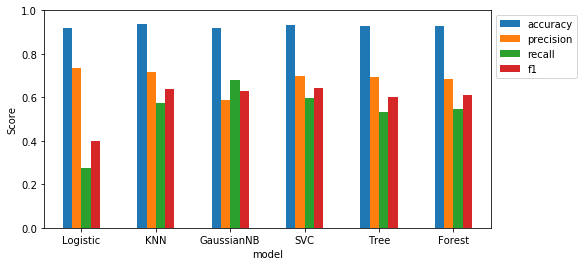

In [19]:
df = df_score

df[['model','accuracy', 'precision', 'recall', 'f1']].plot(x='model', kind='bar', figsize=(8, 4), legend=False)
plt.legend(bbox_to_anchor=(1,1), ncol = 1)
plt.ylim([0.0, 1])
plt.ylabel('Score')
# plt.xlabel()
plt.xticks(rotation=0)
plt.show();

## Train-test error
* check 1) the effect of training size (sensitivity) and 2) under/over fitting
* loop through a few models and check the trends of train/test error

Covid data
* it looks that train/test errors converge very quick 

Logistic
KNN
GaussianNB
SVC
Tree
Forest


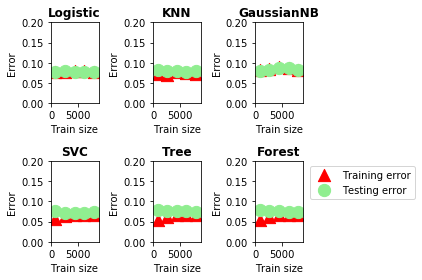

In [20]:
# plt.figure(figsize=(15,7))

mydict_models =  {
    'Logistic': LogisticRegression(), 
    'KNN': KNeighborsClassifier(), 
    'GaussianNB': GaussianNB(),
    'SVC': SVC(), 
    'Tree': DecisionTreeClassifier(), 
    'Forest': RandomForestClassifier()
}

for index, value in enumerate(mydict_models.keys()):
    model_name = value
    model = mydict_models[value]
    print(model_name)
    
# for index, k in enumerate(range(1, 30, 5)):
#     model = KNeighborsClassifier(n_neighbors=k)
#     model_name = 'KNN-' + str(int(k))
    
    plot_id = '23{}'.format(index+1)
    plt.subplot(plot_id)
    plt.title('{}'.format(model_name), weight='bold')

    train_sizes, train_scores, valid_scores = learning_curve(model, X, y)
    train_err = 1- train_scores
    ts_err = 1- valid_scores
    
    train_cv_err = np.mean(train_err, axis=1)
    test_cv_err = np.mean(ts_err, axis=1)
    
    plt.scatter(train_sizes, train_cv_err, marker= '^', color='red', s = 150, label = 'Training error')
    plt.scatter(train_sizes, test_cv_err, marker='o', color='lightgreen', s =150, label = 'Testing error')

    plt.xlabel('Train size')
    plt.ylabel('Error')
    plt.ylim([0,0.2])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=1)
plt.tight_layout()

plt.show();

## Confusion matrix

In [21]:
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Logistic
KNN
GaussianNB
SVC
Tree
Forest


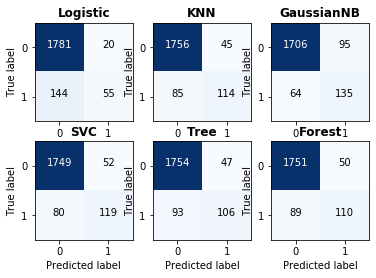

In [22]:
# plt.figure(figsize=(12,12), dpi=100)

for index, value in enumerate(mydict_models.keys()):
    model_name = value
    model = mydict_models[value]
    print(model_name)
    
    plot_id = '23{}'.format(index+1)
    plt.subplot(plot_id)
    plt.title('{}'.format(model_name), weight='bold')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    
    plot_confusion_matrix(cm,[0,1])

# plt.tight_layout()
# plt.colorbar()
plt.show();

# - - - Part 3: Model tuning - - -

# KNN

Now, let us look into more details of KNN
* tuning the model, note that our goal is to optimize recall

## Tuning - a simple loop ....

In [23]:
df_score_knn = pd.DataFrame()

for n in range(1, 100, 10):
    model = KNeighborsClassifier(n_neighbors=n)
    model_name = int(n)
    
    model.fit(X_train, y_train);
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    data_onemodel = [model_name, accuracy, precision, recall, f1]
    
    df_temp = pd.DataFrame([data_onemodel])
    df_score_knn = pd.concat([df_score_knn, df_temp])

df_score_knn.columns = ['neighbor', 'accuracy', 'precision', 'recall', 'f1']

df_score_knn.head()

KNeighborsClassifier(n_neighbors=1)

KNeighborsClassifier(n_neighbors=11)

KNeighborsClassifier(n_neighbors=21)

KNeighborsClassifier(n_neighbors=31)

KNeighborsClassifier(n_neighbors=41)

KNeighborsClassifier(n_neighbors=51)

KNeighborsClassifier(n_neighbors=61)

KNeighborsClassifier(n_neighbors=71)

KNeighborsClassifier(n_neighbors=81)

KNeighborsClassifier(n_neighbors=91)

,neighbor,accuracy,precision,recall,f1
0,1,0.926,0.720,0.427,0.536
0,11,0.922,0.720,0.362,0.482
0,21,0.929,0.705,0.492,0.580
0,31,0.922,0.697,0.382,0.494
0,41,0.929,0.699,0.503,0.585


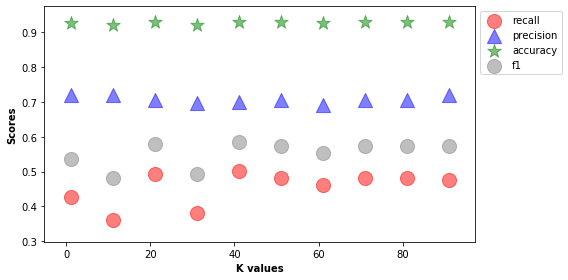

In [24]:
plt.figure(figsize=(8, 4))

list_score = ['recall', 'precision', 'accuracy', 'f1']
list_color = ['r', 'b', 'g', 'grey']
list_marker = ['o', '^', '*', 'o']

df = df_score_knn 

for index, score in enumerate(list_score):
    plt.scatter(df['neighbor'], df[score], marker =list_marker[index], color =list_color[index], s = 200, label = score, alpha = 0.5)

# axes = plt.gca()
    
plt.legend(loc = 'best', bbox_to_anchor=(1,1), ncol = 1)
plt.xlabel('K values', rotation=0, weight='bold')
plt.ylabel('Scores', rotation=90, weight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show();

## Tuning - GridSearchCV

Covid
* GridSearchCV reports similar optimized K of 20 for the recall

In [25]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
grid = dict(n_neighbors=range(1, 100, 10))
# grid = dict(n_neighbors=range(1, 100, 10),weights=['uniform', 'distance'],metric=['euclidean', 'manhattan', 'minkowski'])

# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=10, scoring='recall', error_score=0, return_train_score=True, verbose=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='recall', error_score=0, return_train_score=True, verbose=1)

grid_result = grid_search.fit(X, y)

#  - - - summarize - - -
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

print('\nPrint out the mean score, std score, and prameters')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
df = pd.DataFrame(params)
df['model'] = str(model)
df['score_mean'] = means
df['score_std'] = stds
df_summary = df

df.head()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.473320 using {'n_neighbors': 31}

Print out the mean score, std score, and prameters
0.339600 (0.027036) with: {'n_neighbors': 1}
0.424204 (0.034870) with: {'n_neighbors': 11}
0.410657 (0.054982) with: {'n_neighbors': 21}
0.473320 (0.028659) with: {'n_neighbors': 31}
0.444017 (0.050065) with: {'n_neighbors': 41}
0.457646 (0.018832) with: {'n_neighbors': 51}
0.452400 (0.022834) with: {'n_neighbors': 61}
0.453447 (0.025302) with: {'n_neighbors': 71}
0.446128 (0.026765) with: {'n_neighbors': 81}
0.437773 (0.027414) with: {'n_neighbors': 91}


,n_neighbors,model,score_mean,score_std
0,1,KNeighborsClassifier(),0.340,0.027
1,11,KNeighborsClassifier(),0.424,0.035
2,21,KNeighborsClassifier(),0.411,0.055
3,31,KNeighborsClassifier(),0.473,0.029
4,41,KNeighborsClassifier(),0.444,0.050


In [26]:
# Predefine a few functions for plotting
# source: https://www.semicolonworld.com/question/43851/how-to-add-group-labels-for-bar-charts-in-matplotlib

from itertools import groupby

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos], transform=ax.transAxes, color='black', linewidth=0.5)
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index, level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0

        angle = 90 if level == 10 else 0
        alpha = 0 if level == 10 else 1

        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes, rotation=angle, c= 'black', alpha = alpha)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1


<Figure size 1000x400 with 0 Axes>

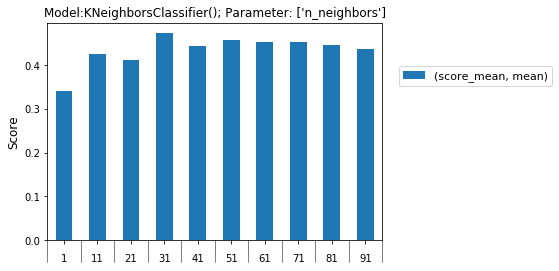

In [27]:
df = df_summary

col_groupby = list(params[0].keys())
col_agg = ['mean']
col_variable, y_label = ['score_mean'], 'Score'

plt.figure(figsize=(10, 4), dpi=100)

df[col_variable] = df[col_variable].astype(float)

df_ave = df.groupby(col_groupby).agg(col_agg)[col_variable]
df_std = df.groupby(col_groupby)[col_variable].std()

ax = df_ave.plot(kind='bar', stacked = True, color = 'tab:blue')
# ax = df_ave.plot(kind='bar', stacked = False, yerr = df_std, error_kw=dict(capsize=3, lw=1, capthick=0.5), edgecolor = "black")

ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, df_ave)

plt.legend(bbox_to_anchor=(1.05, 0.8), fontsize = 11, loc='upper left', borderaxespad=0.)
plt.ylabel(y_label, fontsize = 12)
plt.title('Model:' + str(model) + '; Parameter: ' + str(col_groupby), fontsize = 12)
plt.show();

# Logistic

## Quick fit

In [28]:
lr = LogisticRegression(C=10000) # C large enough to remove regularization
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('recall: ', round(recall_score(y_pred, y_test), 4))
print('f1:', round(f1_score(y_pred, y_test), 4))

LogisticRegression(C=10000)

recall:  0.7403
f1: 0.413


## confusion matrix

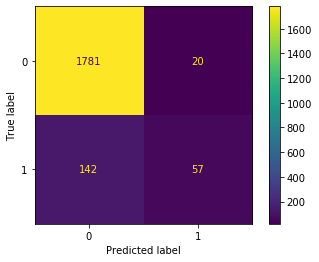

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred) # normalize=None

# plot #1
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.grid(False)

# plot #2
# sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True,
#            xticklabels = target_values,
#            yticklabels = target_values)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion matrix')
# plt.yticks(rotation=0);

## confusion matrix - interactive
* this is particularly useful in tuning the threshold/probability

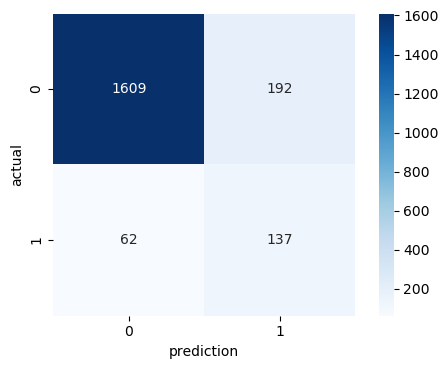

In [30]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
#     fraud_confusion = confusion_matrix(y_test, y_predict, normalize='true')
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d', xticklabels=target_values, yticklabels=target_values)
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.show();

make_confusion_matrix(lr, threshold = 0.05)

In [31]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(lr, threshold), threshold=(0.0,1,0.2))

interactive(children=(FloatSlider(value=0.4, description='threshold', max=1.0, step=0.2), Output()), _dom_clas…

## Threshold (*P*) tuning (ROC) (*)

In [32]:
model = LogisticRegression(C=10000) # C large enough to remove regularization
model.fit(X_train, y_train)
# model_test_probs = model.predict(X_test)

thresh_ps = np.linspace(0.01,0.95,100)
y_predict_probs = model.predict_proba(X_test)[:,1] # positive class probs, same basic logistic model we fit in section 2 

all_scores = []

for p in thresh_ps:
    y_predict = y_predict_probs >= p
    
#     cm = confusion_matrix(y_test, model_test_labels)
    TN, FP, FN, TP = confusion_matrix(y_test, y_predict).ravel()

    # calculate the metrics
    TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
    TNR = TN/(TN+FP) # Specificity or true negative rate
    PPV = TP/(TP+FP) # Precision or positive predictive value
    NPV = TN/(TN+FN) # Negative predictive value
    FPR = FP/(FP+TN) # Fall out or false positive rate
    FNR = FN/(TP+FN) # False negative rate
    FDR = FP/(TP+FP) # False discovery rate
    ACC = (TP+TN)/(TP+FP+FN+TN)  # Overall accuracy
    
    all_scores.append([p, TN, FP, FN, TP,
                       f1_score(y_test, y_predict), precision_score(y_test, y_predict), 
                       recall_score(y_test, y_predict), accuracy_score(y_test, y_predict),
                      TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC])

# plt.show(); # TM: semicolon does not suppress when plotting unless at the end

LogisticRegression(C=10000)

In [33]:
all_names = ['threshold', 'TN', 'FP', 'FN', 'TP', 'f1', 'precision', 'recall', 'accuracy', 'TPR', 'TNR', 'PPV', 'NPV', 'FPR', 'FNR', 'FDR', 'ACC']

df = pd.DataFrame(all_scores)
df.columns = all_names

df_score = df

df.head()

,threshold,TN,FP,FN,TP,f1,precision,recall,accuracy,TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC
0,0.010,0,1801,0,199,0.181,0.100,1.000,0.100,1.000,0.000,0.100,NaN,1.000,0.000,0.900,0.100
1,0.019,3,1798,1,198,0.180,0.099,0.995,0.101,0.995,0.002,0.099,0.750,0.998,0.005,0.901,0.101
2,0.029,14,1787,2,197,0.180,0.099,0.990,0.105,0.990,0.008,0.099,0.875,0.992,0.010,0.901,0.105
3,0.038,809,992,30,169,0.249,0.146,0.849,0.489,0.849,0.449,0.146,0.964,0.551,0.151,0.854,0.489
4,0.048,935,866,34,165,0.268,0.160,0.829,0.550,0.829,0.519,0.160,0.965,0.481,0.171,0.840,0.550


In [34]:
df = df_score

print('find the highest f1')
df.sort_values(by=['f1'], ascending = False).head(1)

print('find the highest recall')
df.sort_values(by=['recall'], ascending = False).head(1)

find the highest f1


,threshold,TN,FP,FN,TP,f1,precision,recall,accuracy,TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC
19,0.19,1740,61,71,128,0.66,0.677,0.643,0.934,0.643,0.966,0.677,0.961,0.034,0.357,0.323,0.934


find the highest recall


,threshold,TN,FP,FN,TP,f1,precision,recall,accuracy,TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC
0,0.01,0,1801,0,199,0.181,0.1,1.0,0.1,1.0,0.0,0.1,NaN,1.0,0.0,0.9,0.1


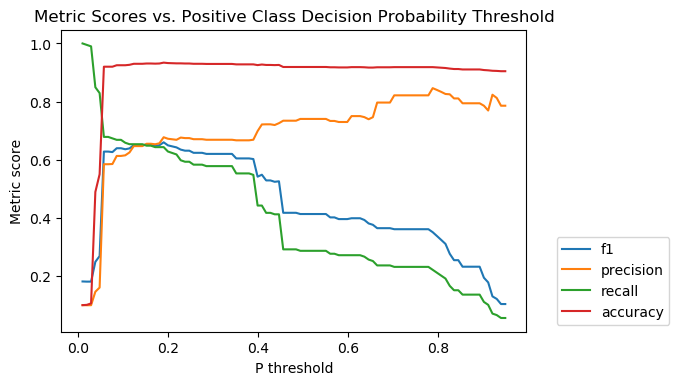

In [35]:
df = df_score
col_plot = ['f1', 'precision', 'recall', 'accuracy']

plt.figure(figsize=(6,4), dpi=100)

for col in col_plot:
    plt.plot(df['threshold'], df[col])
    
plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(col_plot, bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')
plt.show();

# plt.plot(df['threshold'], df['f1'])
# plt.plot(df['threshold'], df['precision'])
# plt.plot(df['threshold'], df['recall'])
# plt.plot(df['threshold'], df['accuracy'])

# plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
# plt.legend(['F1','Precision','Recall/FPR','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
# plt.xlabel('P threshold')
# plt.ylabel('Metric score')
# plt.show();

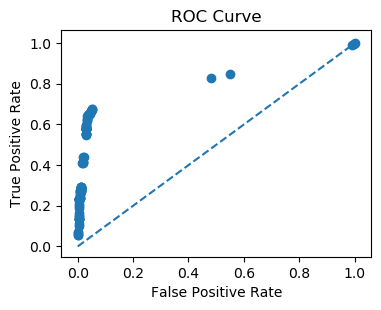

In [36]:
plt.figure(figsize=(4,3), dpi=100)

df = df_score
plt.scatter(df['FPR'], df['TPR'])

x = np.linspace(0,1, 1000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show();

## Precision-recall trade-off

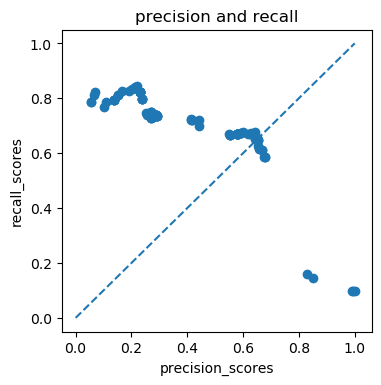

In [37]:
plt.figure(figsize=(4,4), dpi=100)

df = df_score

plt.scatter(df['recall'], df['precision'])

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('precision and recall')
plt.xlabel('precision_scores')
plt.ylabel('recall_scores')

plt.show();

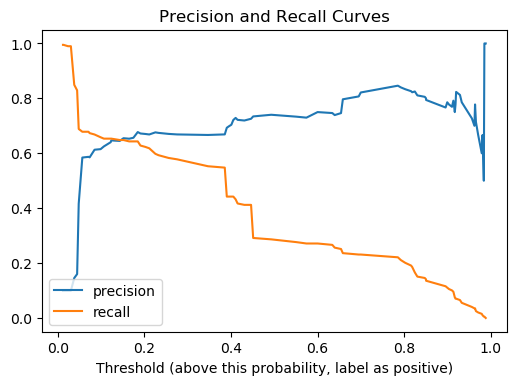

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

# another way of ploting precision-recall
model = LogisticRegression(C = 100)
model.fit(X_train, y_train)

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1] )

plt.figure(dpi=100)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as positive)');
plt.title('Precision and Recall Curves');

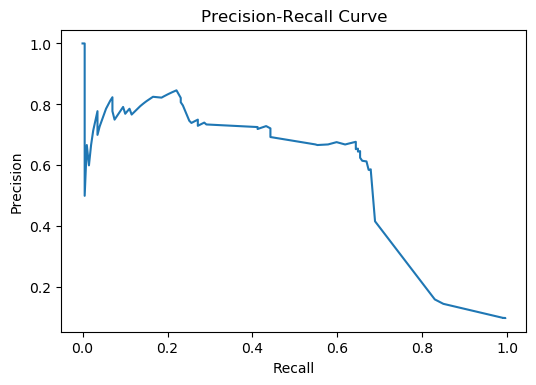

In [39]:
plt.figure(dpi=100)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

## feature importance

In [40]:
# get the coeff, log coeff, and probability for the default model

lr_model_all = LogisticRegression()
lr_model_all.fit(X_train, y_train)

print('coefs:', lr_model_all.coef_[0])

print('exp(coef):', np.exp(lr_model_all.coef_[0]))

df_coefficients = {'feature': X_train.columns, 
        'coeff (log odd) - log loss': lr_model_all.coef_[0],
       'proba (odds)': np.exp(lr_model_all.coef_[0]),
       'proba (% in increase)': ["{:.1%}".format(item-1) for item in np.exp(lr_model_all.coef_[0])]}

# pd.DataFrame.from_dict(data_coefficients).head()
pd.DataFrame.from_dict(df_coefficients).sort_values(by=['proba (odds)'], ascending = False)

LogisticRegression()

coefs: [ 0.84564225  1.70431373  1.03665064  1.16304029  1.74821385  0.16420461
  0.24765607  2.75079684 -1.14587227]
exp(coef): [ 2.32947343  5.49761155  2.81975681  3.19964635  5.74433326  1.17845542
  1.28101928 15.65510159  0.31794646]


,feature,coeff (log odd) - log loss,proba (odds),proba (% in increase)
7,contact_with_confirmed,2.751,15.655,1465.5%
4,head_ache,1.748,5.744,474.4%
1,fever,1.704,5.498,449.8%
3,shortness_of_breath,1.163,3.200,220.0%
2,sore_throat,1.037,2.820,182.0%
0,cough,0.846,2.329,132.9%
6,gender,0.248,1.281,28.1%
5,age_60_and_above,0.164,1.178,17.8%
8,abroad,-1.146,0.318,-68.2%


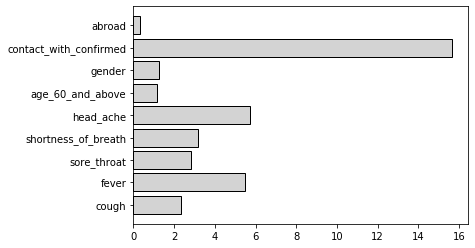

In [41]:
df = df_coefficients
plt.barh(df['feature'], width=df['proba (odds)'], color = 'lightgrey', edgecolor = 'black');

## feature importance (bootstrapped)
* bootstrapping generates bags of dataset to estimate the variation of the coefficients / feature importance
* `df_coef`: the dataframe that stores all fitted logistic-regression coefficients
* `df_coef`: # of rows = # of bags, # of columns = # feature + 1 (1 here is the intercept)

In [42]:
df_train = X_train.copy()
df_train[col_y] = y_train.copy()

# adjust as needed
bags, samples = 1000, 10000 
# samples = X_train.shape[0]

df_coef = pd.DataFrame()

show_progress = 0

for index, item in enumerate(range(bags)):
    
    progress = index/bags
    if progress < show_progress: pass
    else: print('Progress:', "{:.0%}".format(show_progress)); show_progress = show_progress + 0.1    
    
    # bootstrap with replacement enabled
    df_bootstrap = df_train.sample(n=samples, replace=True)

    X_sample = np.array(df_bootstrap[col_X])
    y_sample = np.array(df_bootstrap[col_y])
    
    model = LogisticRegression().fit(X_sample, y_sample)
    coefficients = list(model.coef_[0]) + list([model.intercept_][0])

    df_temp = pd.DataFrame([coefficients])
    df_coef  = pd.concat([df_coef, df_temp])
    
df_coef.columns = list(X_train.columns) + ['intercept']

df_coef.shape
df_coef.head()

Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%


(1000, 10)

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,contact_with_confirmed,abroad,intercept
0,0.536,1.790,0.949,1.889,1.969,0.239,0.208,2.864,-0.943,-3.201
0,0.860,1.706,0.794,1.674,1.995,0.312,0.254,2.694,-1.167,-3.246
0,0.774,1.807,1.260,1.438,1.438,0.248,0.356,2.737,-0.946,-3.213
0,0.903,1.585,0.656,0.418,2.003,0.106,0.125,2.766,-1.506,-3.105
0,1.232,1.235,1.163,0.654,1.939,0.283,0.153,2.712,-1.881,-3.196


In [43]:
# df: confidence internval

df = pd.DataFrame()

list_mean = []
list_lower = []
list_upper = []

for col in df_coef.columns:
    data = df_coef[col]
    a, b, c = np.percentile(data, 2.5), np.mean(data), np.percentile(data, 97.5)
    print('col_name:', col, '; percentiles:', round(a, 4), round(b, 4), round(c, 4))
    list_lower.append(np.percentile(data, 2.5))
    list_mean.append(np.mean(data))
    list_upper.append(np.percentile(data, 97.5))
    
df['feature'] = df_coef.columns
df['lower'] = list_lower
df['lower_exp'] = [np.exp(item) for item in list_lower]
df['lower_prob'] = ["{:.1%}".format(np.exp(item)-1) for item in list_lower]
df['mean'] = list_mean
df['mean_exp'] = [np.exp(item) for item in list_mean]
df['mean_prob'] = ["{:.1%}".format(np.exp(item)-1) for item in list_mean]
df['upper'] = list_upper
df['upper_exp'] = [np.exp(item) for item in list_upper]
df['upper_prob'] = ["{:.1%}".format(np.exp(item)-1) for item in list_upper]
df['interval'] = (df['upper'] - df['lower'])/2
df['interval_exp'] = (df['upper_exp'] - df['lower_exp'])/2
df['interval_prob'] = [ ((np.exp(list_upper[index])-1) -  (np.exp(list_lower[index])-1))/2  for index, item in enumerate(list_upper)]

# remove the intercept row and rank
df = df[~(df['feature'].str.contains('intercept'))]
df = df.sort_values(by=['mean'], ascending = True)

df_CI = df

df.head(10)

col_name: cough ; percentiles: 0.4711 0.8465 1.203
col_name: fever ; percentiles: 1.3479 1.7111 2.0862
col_name: sore_throat ; percentiles: 0.4264 1.055 1.6573
col_name: shortness_of_breath ; percentiles: 0.0732 1.2038 2.2264
col_name: head_ache ; percentiles: 1.3098 1.7611 2.2683
col_name: age_60_and_above ; percentiles: -0.0576 0.1608 0.3698
col_name: gender ; percentiles: 0.0848 0.2508 0.4114
col_name: contact_with_confirmed ; percentiles: 2.5502 2.7655 2.9848
col_name: abroad ; percentiles: -1.8886 -1.2167 -0.6372
col_name: intercept ; percentiles: -3.3543 -3.2202 -3.0854


,feature,lower,lower_exp,lower_prob,mean,mean_exp,mean_prob,upper,upper_exp,upper_prob,interval,interval_exp,interval_prob
8,abroad,-1.889,0.151,-84.9%,-1.217,0.296,-70.4%,-0.637,0.529,-47.1%,0.626,0.189,0.189
5,age_60_and_above,-0.058,0.944,-5.6%,0.161,1.174,17.4%,0.370,1.447,44.7%,0.214,0.252,0.252
6,gender,0.085,1.088,8.8%,0.251,1.285,28.5%,0.411,1.509,50.9%,0.163,0.210,0.210
0,cough,0.471,1.602,60.2%,0.847,2.332,133.2%,1.203,3.330,233.0%,0.366,0.864,0.864
2,sore_throat,0.426,1.532,53.2%,1.055,2.872,187.2%,1.657,5.245,424.5%,0.615,1.857,1.857
3,shortness_of_breath,0.073,1.076,7.6%,1.204,3.333,233.3%,2.226,9.267,826.7%,1.077,4.095,4.095
1,fever,1.348,3.849,284.9%,1.711,5.535,453.5%,2.086,8.054,705.4%,0.369,2.102,2.102
4,head_ache,1.310,3.705,270.5%,1.761,5.819,481.9%,2.268,9.663,866.3%,0.479,2.979,2.979
7,contact_with_confirmed,2.550,12.810,1181.0%,2.765,15.886,1488.6%,2.985,19.782,1878.2%,0.217,3.486,3.486


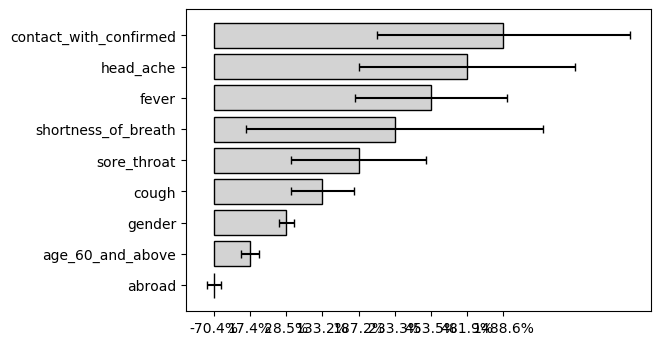

In [44]:
df = df_CI

plt.figure(dpi=100)
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["errorbar.capsize"] = 3

# plt.barh(df['feature'], width=df['mean'], xerr = df['interval'], color = 'lightgrey', edgecolor = 'black')
# plt.barh(df['feature'], width=df['mean'], xerr = df['interval'], color = 'lightgrey', edgecolor = 'black')
plt.barh(df['feature'], width=df['mean_prob'], xerr = df['interval_prob'], color = 'lightgrey', edgecolor = 'black')
# plt.xlim([0,15])
# plt.xticks([0, 5, 10, 15])
# plt.xticks([-1, 1])
plt.show();

## ** Confidence interval
* [NIST](https://www.itl.nist.gov/div898/handbook/eda/section3/eda352.htm): # t1-α/2, N-1 is the 100(1-α/2) percentile of the t distribution with N - 1 degrees of freedom
* NIST: 1.9723*0.022789/√195
* bootstrap looks better for median


(1000000, 1)
mean: -0.0010369043307097354 std: 0.9991877520979894


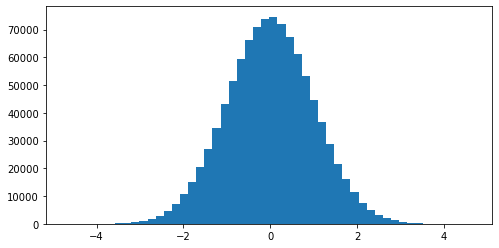

In [45]:
mu, sigma = 0, 1 # mean and standard deviation
data = np.random.normal(mu, sigma, 1000000)

df = pd.DataFrame(data, columns = ['value'])

print(df.shape)
print('mean:', np.mean(df['value']), 'std:', np.std(df['value']))
# df.head()


plt.hist(df['value'], bins = 50);

-0.0633 -0.0017 0.0615
mean: -0.0017 ; entire internval: 0.1248


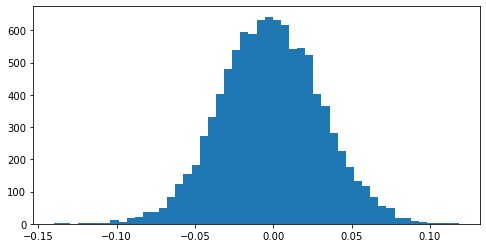

In [46]:
# estimate the mean value for each bootstrapped bag
# and add it to the list

means = []
bags, samples = 10000, 1000 

for item in range(bags):
    df_bootstrap = df.sample(n=samples, replace=True)
    values = list(df_bootstrap['value'])
    means.append(np.mean(values))

data = means
a, b, c = np.percentile(data, 2.5), np.mean(data), np.percentile(data, 97.5)
print(round(a, 4), round(b, 4), round(c, 4))
print('mean:', round(b, 4), '; entire internval:', round(c-a, 4))

plt.hist(data, bins=50);

(-0.0728, -0.0126, 0.048, 0.1204)


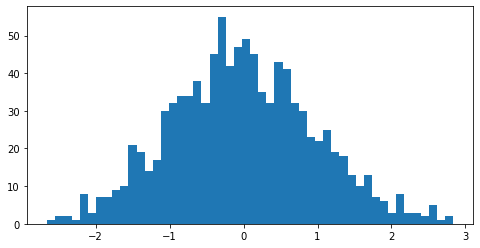

In [47]:
# method 1
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return round(m-h, 4), round(m, 4), round(m+h,3), round(2*h, 4)

data = df['value'].sample(n=samples, replace=False)
print(mean_confidence_interval(data))

plt.hist(data, bins=50);

In [48]:
# from scipy import stats

# def mean_confidence_interval(data, confidence=0.95):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     m, se = np.mean(a), stats.sem(a)
#     h = se * stats.t.ppf((1 + confidence) / 2., n-1)
#     return round(m-h, 4), round(m, 4), round(m+h,3), round(2*h, 4)

# data = df['value'].sample(n=n_boot, replace=False)
# mean_confidence_interval(data)

# # assuming t = 1.96
# print('Entire interval distance (assuming t = 1.96):', round(2*abs(1.96*np.std(data)/((len(data))**0.5)), 4))

# # from my GSMPM Cleveland code
# CIs = [np.std(data) * stats.t.ppf(1-0.025, len(data)-1)/ (len(data)**0.5)]
# print(print('Entire interval distance:', round(2*CIs[0], 4)))

# Random Forest

## Quick fit and check score

In [49]:
# check input data again
print(X.shape, X_train.shape, X_test.shape, y.shape, y_train.shape, y_test.shape)

(10000, 9) (8000, 9) (2000, 9) (10000, 1) (8000, 1) (2000, 1)


In [50]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('recall: ', round(recall_score(y_pred, y_test), 4))
print('f1:', round(f1_score(y_pred, y_test), 4))
confusion_matrix(y_test, y_pred)

RandomForestClassifier()

recall:  0.689
f1: 0.6226


array([[1750,   51],
       [  86,  113]], dtype=int64)

## Tuning - GridSearchCV

In [51]:
model = RandomForestClassifier()

score = 'recall'
grid = dict(n_estimators=[10, 100, 1000],max_features=['sqrt', 'log2'])

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring=score, error_score=0, return_train_score=True, verbose=1)

grid_result = grid_search.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

df = pd.DataFrame(params)
df['model'] = str(model)
df[score+'_mean'] = means
df[score+'_std'] = stds
df_summary = df

df.head()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best: 0.528681 using {'max_features': 'log2', 'n_estimators': 10}


,max_features,n_estimators,model,recall_mean,recall_std
0,sqrt,10,RandomForestClassifier(),0.515,0.029
1,sqrt,100,RandomForestClassifier(),0.523,0.025
2,sqrt,1000,RandomForestClassifier(),0.523,0.026
3,log2,10,RandomForestClassifier(),0.529,0.029
4,log2,100,RandomForestClassifier(),0.517,0.029


## Feature importance

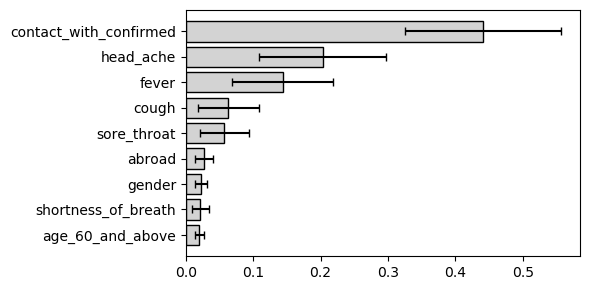

In [52]:
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams["errorbar.capsize"] = 3

feature_names = X_train.columns
forest = RandomForestClassifier(random_state=0)
# forest = RandomForestClassifier(random_state=0, n_estimators=1000, max_features='sqrt')
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
df_forest_importances = pd.DataFrame(importances, index=feature_names, columns=['importance'])
df_forest_importances['std'] = std
df_forest_importances['feature'] = df_forest_importances.index
df_forest_importances = df_forest_importances.sort_values(by =['importance'], ascending = True)
plt.barh(df_forest_importances['feature'], width=df_forest_importances['importance'], xerr = df_forest_importances['std'], color = 'lightgrey', edgecolor = 'black')
plt.tight_layout()
plt.show();

#  Compare two models

## Score models on test set
* TM: using the covid data, a reshape of `.reshape(-1,1)` is needed for data feeding

In [53]:
# check input data again
print(X.shape, X_train.shape, X_test.shape, y.shape, y_train.shape, y_test.shape)

(10000, 9) (8000, 9) (2000, 9) (10000, 1) (8000, 1) (2000, 1)


In [54]:
lr = LogisticRegression(C=10000) # C large enough to remove regularization
lr.fit(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(X_train, y_train)

y_pred = lr.predict(X_test).reshape(-1,1)
print('Logistic regression validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_test, y_pred), 
         precision_score(y_test, y_pred), 
         recall_score(y_test, y_pred), 
         f1_score(y_test, y_pred), 
        )
     )

print('\n')

y_pred = knn.predict(X_test).reshape(-1,1)
print('10 nearest neighbors validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_test, y_pred), 
         precision_score(y_test, y_pred), 
         recall_score(y_test, y_pred), 
         f1_score(y_test, y_pred), 
        )
     )

LogisticRegression(C=10000)

KNeighborsClassifier(n_neighbors=91)

Logistic regression validation metrics: 
 Accuracy: 0.9190 
 Precision: 0.7403 
 Recall: 0.2864 
 F1: 0.4130


10 nearest neighbors validation metrics: 
 Accuracy: 0.9295 
 Precision: 0.7197 
 Recall: 0.4774 
 F1: 0.5740


## ROC (> 1 models)

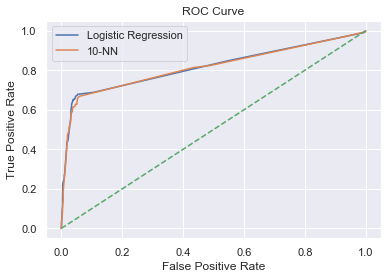

In [55]:
# Hint: First create a function that calculates the false positive rate.
    
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

def fpr(actuals, preds):
    fp = np.sum((actuals == 0) & (preds == 1))
    tn = np.sum((actuals == 0) & (preds == 0))
    return fp / (fp + tn)    

def plot_ROC_curve(model, X, y):
    
    probs = model.predict_proba(X)[:,1].reshape(-1,1)
    fprs, tprs = [],[]
    
    for p in np.linspace(1,0,100):
        preds = probs >= p
        fprs.append(fpr(y, preds))
        tprs.append(recall_score(y, preds))
    
    plt.plot(fprs, tprs)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
            
plot_ROC_curve(lr, X_test, y_test) 
plot_ROC_curve(knn, X_test, y_test) 
x_axis = np.linspace(0, 1, 10)
plt.plot(x_axis, x_axis, linestyle='--')
plt.legend(['Logistic Regression','10-NN'])

plt.show();

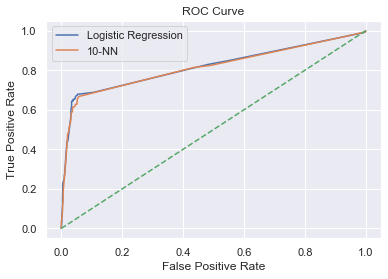

In [56]:
# Finally, here's how we could do the same thing with sklearn.

from sklearn.metrics import roc_curve

# first model: lr
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

# second model: knn
fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Regression','10-NN'])

plt.show();

# `GridSearchCV` (*)
* `GridSearchCV` for Hyperparameters
* source-1: https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
* source-2: https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

**Variables for tuning**
* scoring: recall, accuracy

**List: Model and parameters** 
1. Logistic Regression
    * solver: [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
    * Regularization (penalty): [‘none’, ‘l1’, ‘l2’, ‘elasticnet’]
    * C parameter (penalty strength): [100, 10, 1.0, 0.1, 0.01]


2. Ridge Classifier
    * alpha (regularization strength): [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


3. K-Nearest Neighbors (KNN)
    * n_neighbors: [1 to 21]
    * metric: [‘euclidean’, ‘manhattan’, ‘minkowski’]
    * weights: [‘uniform’, ‘distance’]


4. Support Vector Machine (SVM)
    * kernels: [‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’]
    * C (penalty): [100, 10, 1.0, 0.1, 0.001]


5. Bagged Decision Trees (Bagging
    * n_estimators (number of trees): [10, 100, 1000]


6. Random Forest
    * max_features (the number of random features to sample at each split point): [1 to 20], or [‘sqrt’, ‘log2’]
    * n_estimators (number of trees): [10, 100, 1000]


7. Stochastic Gradient Boosting (GBM, XGBoost)
    * learning_rate: [0.001, 0.01, 0.1]
    * n_estimators (# of trees): [10, 100, 1000]
    * subsample: [0.5, 0.7, 1.0]
    * max_depth (): [3, 7, 9]

## One model: test

In [57]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [58]:
# define dataset
# X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)
# print(X.shape, y.shape)

# 1. Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
grid = dict(solver=['newton-cg', 'lbfgs', 'liblinear'],penalty=['l2'],C=[100, 10, 1.0, 0.1, 0.01])

# # 2. Ridge Classifier
# from sklearn.linear_model import RidgeClassifier
# model = RidgeClassifier()
# grid = dict(alpha=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# # 3. K-Nearest Neighbors (KNN)
# from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier()
# grid = dict(n_neighbors=range(1, 21, 2),weights=['uniform', 'distance'],metric=['euclidean', 'manhattan', 'minkowski'])

# # 4. Support Vector Machine (SVM)
# from sklearn.svm import SVC
# model = SVC()
# grid = dict(kernel=['poly', 'rbf', 'sigmoid'],C=[50, 10, 1.0, 0.1, 0.01],gamma=['scale'])

# # 5. Bagged Decision Trees (Bagging)
# from sklearn.ensemble import BaggingClassifier
# model = BaggingClassifier()
# grid = dict(n_estimators=[10, 100, 1000])

# # 6. Random Forest
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier()
# grid = dict(n_estimators=[10, 100, 1000],max_features=['sqrt', 'log2'])

# # 7. Stochastic Gradient Boosting
# from sklearn.ensemble import GradientBoostingClassifier
# model = GradientBoostingClassifier()
# grid = dict(learning_rate= [0.001, 0.01, 0.1], n_estimators=[10, 100, 1000], subsample=[0.5, 0.7, 1.0], max_depth=[3, 7, 9])

# - - - modeling - - -
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# parameters: cv, scoring,

score = 'recall'
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=10, scoring='recall', error_score=0, return_train_score=True, verbose=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring=score, error_score=0, return_train_score=True, verbose=1)

grid_result = grid_search.fit(X, y)

#  - - - summarize results - - -
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

print('\nPrint out the mean score, std score, and prameters')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
df = pd.DataFrame(params)
df['model'] = str(model)
df[score+'_mean'] = means
df[score+'_std'] = stds
df_summary = df

df.head()

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best: 0.311344 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

Print out the mean score, std score, and prameters
0.311344 (0.032383) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.311344 (0.032383) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.311344 (0.032383) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.311344 (0.032383) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.311344 (0.032383) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.311344 (0.032383) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.311344 (0.032383) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.311344 (0.032383) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.311344 (0.032383) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.291503 (0.025086) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.291503 (0.025086) with: {'C': 0.1, 'penalty': 'l2', 'solve

,C,penalty,solver,model,recall_mean,recall_std
0,100.0,l2,newton-cg,LogisticRegression(),0.311,0.032
1,100.0,l2,lbfgs,LogisticRegression(),0.311,0.032
2,100.0,l2,liblinear,LogisticRegression(),0.311,0.032
3,10.0,l2,newton-cg,LogisticRegression(),0.311,0.032
4,10.0,l2,lbfgs,LogisticRegression(),0.311,0.032


## One model: barplot

In [59]:
# Predefine a few functions for plotting
# source: https://www.semicolonworld.com/question/43851/how-to-add-group-labels-for-bar-charts-in-matplotlib

from itertools import groupby

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos], transform=ax.transAxes, color='black', linewidth=0.5)
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index, level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        
        angle = 90 if level == 10 else 0
        alpha = 0 if level == 10 else 1
        
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes, rotation=angle, c= 'black', alpha = alpha)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

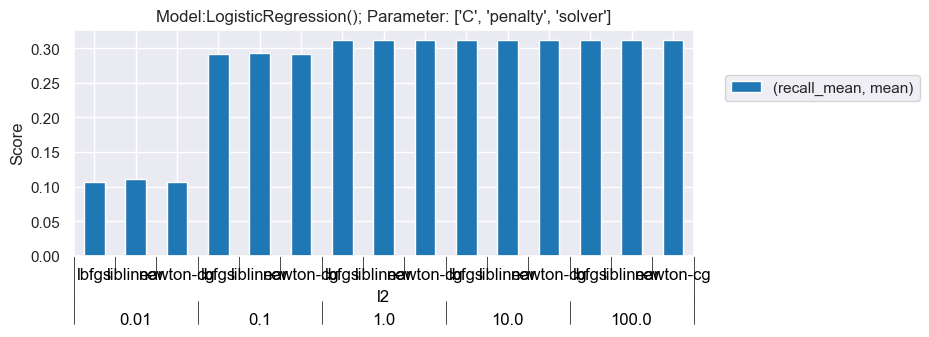

In [60]:
df = df_summary

col_groupby = list(params[0].keys())
col_agg = ['mean']
col_variable, y_label = [score+'_mean'], 'Score'

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (8,3)

df[col_variable] = df[col_variable].astype(float)

df_ave = df.groupby(col_groupby).agg(col_agg)[col_variable]
df_std = df.groupby(col_groupby)[col_variable].std()

ax = df_ave.plot(kind='bar', stacked = True, color = 'tab:blue')
# ax = df_ave.plot(kind='bar', stacked = False, yerr = df_std, error_kw=dict(capsize=3, lw=1, capthick=0.5), edgecolor = "black")

ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, df_ave)

plt.legend(bbox_to_anchor=(1.05, 0.8), fontsize = 11, loc='upper left', borderaxespad=0.)
plt.ylabel(y_label, fontsize = 12)
plt.title('Model:' + str(model) + '; Parameter: ' + str(col_groupby), fontsize = 12)
plt.show();

## Multiple models (slow)
1. identify models, hyper-parameters, and score (*recall* - minimize the false negative)
2. go crazy and run all combinations (we should do this only after a coarse tuning for each model)
2. ave all model names, parameter combinations, and scores into a data frame (for ploting) 

In [61]:
mydict_model =  {
    LogisticRegression(): dict(solver=['newton-cg', 'lbfgs', 'liblinear'],penalty=['l2'],C=[100, 10, 1.0, 0.1, 0.01]), 
    RidgeClassifier(): dict(alpha=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
    KNeighborsClassifier(): dict(n_neighbors=range(1, 21, 2),weights=['uniform'],metric=['euclidean']),
    SVC(): dict(kernel=['poly', 'rbf'],C=[10, 1.0, 0.1, 0.01],gamma=['scale']),
    BaggingClassifier(): dict(n_estimators=[10, 100, 1000]), 
    RandomForestClassifier(): dict(n_estimators=[10, 100, 1000],max_features=['sqrt', 'log2']),
    GradientBoostingClassifier(): dict(learning_rate= [0.01, 0.1], n_estimators=[10, 100, 1000], subsample=[0.5, 0.7, 1.0], max_depth=[3, 7])
}

score = 'recall'

In [62]:
# save the model, parameters, and metrics into a dataframe
df_ModelPerformance = pd.DataFrame()

import time

for key, value in mydict_model.items():
    
    start_time = time.time()
    
    model = key
    grid = value
    print('\nTesting this model:', key, value)
    
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring=score, error_score=0, return_train_score=True, verbose=10)

    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    model_name = str(model)
    
    df = pd.DataFrame(params)
    df.columns = [model_name + '_' + item for item in df.columns]
    df['model'] = model_name
    df['score_mean'] = means
    df['score_std'] = stds
    df_ModelPerformance = pd.concat([df_ModelPerformance, df])
    
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: "f"{elapsed_time:.3f} seconds")


Testing this model: LogisticRegression() {'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'penalty': ['l2'], 'C': [100, 10, 1.0, 0.1, 0.01]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best: 0.311344 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Elapsed time to compute the importances: 0.966 seconds

Testing this model: RidgeClassifier() {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.341612 using {'alpha': 0.1}
Elapsed time to compute the importances: 0.405 seconds

Testing this model: KNeighborsClassifier() {'n_neighbors': range(1, 21, 2), 'weights': ['uniform'], 'metric': ['euclidean']}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.461884 using {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Elapsed time to compute the importances: 35.248 seconds

Testing this model: SVC() {'kernel': ['poly', 'rbf'], 'C': [10, 1.0, 0.1, 0.01], 'gamma':

In [63]:
df = df_ModelPerformance

# adjust column order
col_key = ['model', 'score_mean', 'score_std']
col_rest = [item for item in df.columns if item not in col_key]
df = df[col_key + col_rest]
df.shape
df.head()

(88, 20)

,model,score_mean,score_std,LogisticRegression()_C,LogisticRegression()_penalty,LogisticRegression()_solver,RidgeClassifier()_alpha,KNeighborsClassifier()_metric,KNeighborsClassifier()_n_neighbors,KNeighborsClassifier()_weights,SVC()_C,SVC()_gamma,SVC()_kernel,BaggingClassifier()_n_estimators,RandomForestClassifier()_max_features,RandomForestClassifier()_n_estimators,GradientBoostingClassifier()_learning_rate,GradientBoostingClassifier()_max_depth,GradientBoostingClassifier()_n_estimators,GradientBoostingClassifier()_subsample
0,LogisticRegression(),0.311,0.032,100.0,l2,newton-cg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LogisticRegression(),0.311,0.032,100.0,l2,lbfgs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LogisticRegression(),0.311,0.032,100.0,l2,liblinear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LogisticRegression(),0.311,0.032,10.0,l2,newton-cg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LogisticRegression(),0.311,0.032,10.0,l2,lbfgs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df = df_ModelPerformance

col_groupby = ['model']
col_agg = ['mean', 'max', 'count']
col_variable = ['score_mean']

df = df.groupby(col_groupby).agg(col_agg)[col_variable].reset_index()
df.columns = ['_'.join(item) for item in df.columns]

df.sort_values(by =['score_mean_mean'], ascending = False)

,model_,score_mean_mean,score_mean_max,score_mean_count
4,RandomForestClassifier(),0.519,0.525,6
0,BaggingClassifier(),0.517,0.517,3
6,SVC(),0.467,0.580,8
2,KNeighborsClassifier(),0.398,0.462,10
5,RidgeClassifier(),0.342,0.342,10
1,GradientBoostingClassifier(),0.326,0.552,36
3,LogisticRegression(),0.267,0.311,15


## RandomGridSearchCV
* may work on *Random* search after the *Grid* search
* https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

In [65]:
# from scipy.stats import loguniform
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import RandomizedSearchCV

# # define model
# model = LogisticRegression()
# # define evaluation
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define search space
# space = dict()
# space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
# space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
# space['C'] = loguniform(1e-5, 100)
# # define search
# search = RandomizedSearchCV(model, space, n_iter=500, scoring='recall', n_jobs=-1, cv=cv, random_state=1)
# # execute search
# result = search.fit(X, y)
# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

# Class imbalance

3 broad categories:
1. **Before model training**: Resampling strategies (oversampling, undersampling)
2. **During model training**: Training with adjusted class weights
3. **After model training**: Adjusting the decision threshold (F1 optimization strategy)

In [66]:
print('Check data:')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(y_train))

n_pos = y_train[y_train[col_y] == 1].dropna().shape[0]
n_neg = y_train[y_train[col_y] == 0].dropna().shape[0]

Check data:
(8000, 9) (2000, 9) (8000, 1) (2000, 1)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


## 1). resampling
* the default recall and F1 scores are improved by oversampling (use more positive results)

In [67]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
ratio = {1 : n_pos * 4, 0 : n_neg} 
print('n_pos =', n_pos, ', n_neg =', n_neg)

# randomly oversample positive samples: create nx as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_train_rs, y_train_rs = ROS.fit_resample(X_train, y_train)

# simple regression model
lr = LogisticRegression(solver='liblinear') 
lr.fit(X_train, y_train)

print('Simple Logistic Regression:')
print('Test F1: %.3f' % f1_score(y_test, lr.predict(X_test)))
print('Test Recall: %.3f' % recall_score(y_test, lr.predict(X_test)))
print('Test AUC: %.3f' % roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

lr_os = LogisticRegression(solver='liblinear') 
lr_os.fit(X_train_rs, y_train_rs)

print('Logistic Regression on Oversampled Train Data:')
print('Test F1: %.3f' % f1_score(y_test, lr_os.predict(X_test)))
print('Test Recall: %.3f' % recall_score(y_test, lr_os.predict(X_test)))
print('Test AUC: %.3f' % roc_auc_score(y_test, lr_os.predict_proba(X_test)[:,1]))

n_pos = 758 , n_neg = 7242


LogisticRegression(solver='liblinear')

Simple Logistic Regression:
Test F1: 0.401
Test Recall: 0.276
Test AUC: 0.818


LogisticRegression(solver='liblinear')

Logistic Regression on Oversampled Train Data:
Test F1: 0.653
Test Recall: 0.633
Test AUC: 0.818


## 2) Adjusting class weights (during model training)

In [68]:
lr = LogisticRegression(solver='liblinear') 
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear')
lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1}, solver='liblinear')

lr.fit(X_train, y_train)
print('Normal Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr.predict(X_test)), roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))

lr_balanced.fit(X_train, y_train)
print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr_balanced.predict(X_test)), roc_auc_score(y_test, lr_balanced.predict_proba(X_test)[:,1])))

lr_4x.fit(X_train, y_train)
print('4:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr_4x.predict(X_test)), roc_auc_score(y_test, lr_4x.predict_proba(X_test)[:,1])));

Normal Logistic Regression Test F1: 0.401, Test AUC: 0.818
Balanced class weights Logistic Regression Test F1: 0.626, Test AUC: 0.818
4:1 class weights Logistic Regression Test F1: 0.656, Test AUC: 0.818


## 3) Threshold Adjustment to Optimize F1 (after model training)

Logistic Regression Model best F1 score 0.655 at prob decision threshold >= 0.186


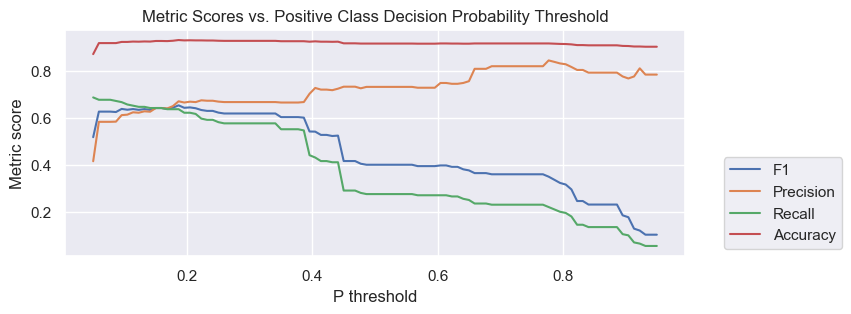

In [69]:
X_val, y_val = X_test, y_test # explicitly calling this validation since we're using it for selection

thresh_ps = np.linspace(0.05, 0.95,100)
model_val_probs = lr.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p));

# Ensembling (Voting, parallel)

## Prep

In [70]:
from sklearn import model_selection

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 9) (2000, 9) (8000, 1) (2000, 1)


In [71]:
# Instantiate four models

from sklearn import linear_model, neighbors, ensemble

lr_model = linear_model.LogisticRegression(solver="lbfgs", random_state=1)
knn_model = neighbors.KNeighborsClassifier()
rf_model = ensemble.RandomForestClassifier(n_estimators=100, random_state=1)
et_model = ensemble.ExtraTreesClassifier(n_estimators=100, random_state=1)

models = ["lr_model", "knn_model", "rf_model", "et_model"]

In [72]:
# Train each model and save as pickle

import pickle

for model_name in models:
    curr_model = eval(model_name)
    curr_model.fit(X_train, y_train)
    with open(f"models/{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile);

LogisticRegression(random_state=1)

KNeighborsClassifier()

RandomForestClassifier(random_state=1)

ExtraTreesClassifier(random_state=1)

In [73]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!

sns.set_style("whitegrid")

# TM, 2021.5.10: conda install mlxtend --channel conda-forge

## Voting classifier

- Max Voting
- Average Voting
- Weighted Voting

In [74]:
# Load pre-trained/tuned models

model_names = ["lr_model", "knn_model", "rf_model", "et_model"]

for model_name in model_names:
    with open(f"models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [75]:
model_list

[('lr_model', LogisticRegression(random_state=1)),
 ('knn_model', KNeighborsClassifier()),
 ('rf_model', RandomForestClassifier(random_state=1)),
 ('et_model', ExtraTreesClassifier(random_state=1))]

In [76]:
# Quick peek at each model performance

for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_test, y_test)}')

lr_model score: 0.918
knn_model score: 0.935
rf_model score: 0.9305
et_model score: 0.9305


## 1) Max Voting (hard)

In [77]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list, voting='hard',  n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=1)),
                             ('knn_model', KNeighborsClassifier()),
                             ('rf_model',
                              RandomForestClassifier(random_state=1)),
                             ('et_model',
                              ExtraTreesClassifier(random_state=1))],
                 n_jobs=-1)

In [78]:
# get score
y_pred = voting_classifer.predict(X_test)
# accuracy_score(y_test, y_pred)
recall_score(y_test, y_pred)

0.5226130653266332

## 2) Average Voting (soft)

In [79]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list, voting='soft',  n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=1)),
                             ('knn_model', KNeighborsClassifier()),
                             ('rf_model',
                              RandomForestClassifier(random_state=1)),
                             ('et_model',
                              ExtraTreesClassifier(random_state=1))],
                 n_jobs=-1, voting='soft')

In [80]:
# Get accuracy
y_pred = voting_classifer.predict(X_test)
# accuracy_score(y_test, y_pred)
recall_score(y_test, y_pred)

0.5628140703517588

## 3)  Weighted Voting
* different weights for different models

In [81]:
# create voting classifier
weights = [1.5,3.8,4.2,2.2]
voting_model = VotingClassifier(estimators=model_list, voting='soft',  weights = weights, n_jobs=-1)
voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=1)),
                             ('knn_model', KNeighborsClassifier()),
                             ('rf_model',
                              RandomForestClassifier(random_state=1)),
                             ('et_model',
                              ExtraTreesClassifier(random_state=1))],
                 n_jobs=-1, voting='soft', weights=[1.5, 3.8, 4.2, 2.2])

In [82]:
# Get accuracy
y_pred = voting_model.predict(X_test)
# accuracy_score(y_test, y_pred)
recall_score(y_test, y_pred)

0.5477386934673367

## 4)  Stacking Classifier

In [83]:
stacked = StackingClassifier(classifiers=model_vars, meta_classifier=LogisticRegression(), use_probas=False)

In [84]:
stacked.fit(X_train, y_train)

StackingClassifier(classifiers=[LogisticRegression(random_state=1),
                                KNeighborsClassifier(),
                                RandomForestClassifier(random_state=1),
                                ExtraTreesClassifier(random_state=1)],
                   meta_classifier=LogisticRegression())

In [85]:
y_pred = stacked.predict(X_test)
# accuracy_score(y_test, y_pred)
recall_score(y_test, y_pred)

0.507537688442211

# Boosting (XGBoost, sequential)

In [86]:
# !conda install -y -c conda-forge xgboost

#######################
# standard code block #
#######################

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

#######################
#       imports       #
#######################
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
import xgboost as xgb

sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


## Classification

In [87]:
# covid data

# X, y = X_copy.copy(), y_copy.copy()
# # X_train, X_test, y_train, y_test = X_train_copy.copy(), X_test_copy.copy(), y_train_copy.copy(), y_test_copy.copy()

# #Split data into 3: 60% train, 20% validation, 20% test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

In [88]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('accuracy:', accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)))
print('recall:', recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)))

accuracy: 0.933
recall: 0.5879396984924623


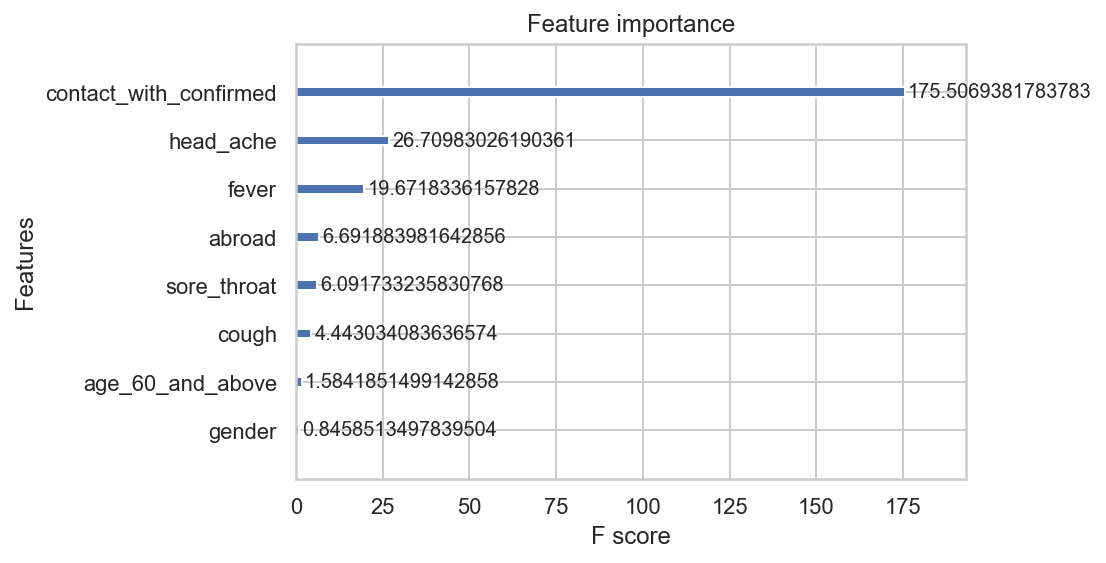

In [89]:
# Interpretation

# read scores
# gbm.get_booster().get_score(importance_type='weight') #extract raw frequency scores
# gbm.get_booster().get_score(importance_type='gain') #extract raw gain scores

# plot feature importance
# xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')
plt.show();

# Streamlit code
* this is the code for the app

In [90]:
# load data
url = 'https://github.com/tangming2008/Datasets_for_projects/blob/master/df_CovidTest_10000rows.pkl'
df = pd.read_pickle(url+ '?raw=true')

col_X = list(df.columns)[0:-1]
col_y = list(df.columns)[-1:]

X = df[col_X]
y = df[col_y]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# classification model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=10000) # C large enough to remove regularization
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

onedata = [0, 1, 1, 0, 0, 0, 0, 1, 0]
df_onedata = pd.DataFrame([onedata])
probability = lr.predict_proba(df_onedata)[:,1]

predict_result = lr.predict(df_onedata)[0]

probability_positive = "{:.0%}".format(probability[0])

print(predict_result, probability_positive)

LogisticRegression(C=10000)

1 94%
